In [10]:
ENV_NAME = 'FetchReach-v1'

METHOD = 'PCHID' # 'PCHID, HER, PPO, HER+PCHID, PPO+PCHID'
REWARD_SUCCESS = 0.0 # can be revised to 10 or more to see the sensitivity of reward value


if METHOD == 'PCHID5':
    LR_PPO = 0.0
    LR_HID = 3e-4
    FUTURE_P = 0.0
    Max_K = 5
elif METHOD == 'HER+PCHID1':
    LR_PPO = 3e-4
    LR_HID = 3e-4
    FUTURE_P = 0.8
    Max_K = 1
elif METHOD == 'PPO+PCHID1':
    LR_PPO = 3e-4
    LR_HID = 3e-4
    FUTURE_P = 0.0
    Max_K = 1
elif METHOD == 'PPO':
    LR_PPO = 3e-4
    LR_HID = 0.0
    FUTURE_P = 0.0
elif METHOD == 'HER':
    LR_PPO = 3e-4
    LR_HID = 0.0
    FUTURE_P = 0.8
elif METHOD == 'PCHID1':
    LR_PPO = 0
    LR_HID = 3e-4
    FUTURE_P = 0.0
    Max_K = 1

In [ ]:
"""
ref: Schulman, John, et al. "Proximal policy optimization algorithms." arXiv preprint arXiv:1707.06347 (2017).
ref: https://github.com/Jiankai-Sun/Proximal-Policy-Optimization-in-Pytorch/blob/master/ppo.py
ref: https://github.com/openai/baselines/tree/master/baselines/ppo2
"""
import torch.nn.functional as F
import random
from copy import deepcopy
from collections import deque
from IPython.display import clear_output
import gym
import torch
import torch.nn as nn
import torch.optim as opt
from torch import Tensor
from torch.autograd import Variable
from collections import namedtuple
from itertools import count
import matplotlib
import matplotlib.pyplot as plt
from os.path import join as joindir
from os import makedirs as mkdir
import pandas as pd
import numpy as np
import argparse
import datetime
import math


for METHOD in ['PCHID1','PCHID5', 'HER', 'PPO', 'HER+PCHID1', 'PPO+PCHID1']:
    ENV_NAME = 'FetchReach-v1'
    REWARD_SUCCESS = 0.0 # can be revised to 10 or more to see the sensitivity of reward value


    if METHOD == 'PCHID5':
        LR_PPO = 0.0
        LR_HID = 3e-4
        FUTURE_P = 0.0
        Max_K = 5
    elif METHOD == 'HER+PCHID1':
        LR_PPO = 3e-4
        LR_HID = 3e-4
        FUTURE_P = 0.8
        Max_K = 1
    elif METHOD == 'PPO+PCHID1':
        LR_PPO = 3e-4
        LR_HID = 3e-4
        FUTURE_P = 0.0
        Max_K = 1
    elif METHOD == 'PPO':
        LR_PPO = 3e-4
        LR_HID = 0.0
        FUTURE_P = 0.0
    elif METHOD == 'HER':
        LR_PPO = 3e-4
        LR_HID = 0.0
        FUTURE_P = 0.8
    elif METHOD == 'PCHID1':
        LR_PPO = 0
        LR_HID = 3e-4
        FUTURE_P = 0.0
        Max_K = 1

    for repeat in range(5):
        class args(object):
            seed = 1234 + repeat
            num_episode = 100
            batch_size = 256
            max_step_per_round = 200
            gamma = 0.995
            lamda = 0.97
            log_num_episode = 1
            num_epoch = 10
            minibatch_size = 256
            clip = 0.2
            loss_coeff_value = 0.5
            loss_coeff_entropy = 0.01

            lr_ppo = LR_PPO
            lr_hid = LR_HID
            future_p = FUTURE_P # param of HER
            Horizon_max = Max_K # param of PCHID
            reward_pos = REWARD_SUCCESS # reward for success 

            num_parallel_run = 1
            # tricks
            schedule_adam = 'linear'
            schedule_clip = 'linear'
            layer_norm = True
            state_norm = True
            advantage_norm = True
            lossvalue_norm = True
            replay_buffer_size_IER = 50000 

        rwds = []
        Succ_recorder = []
        global losses
        Horizon_list = [1]
        losses = [[] for i in range(Max_K) ]

        Transition = namedtuple('Transition', ('state', 'value', 'action', 'logproba', 'mask', 'next_state', 'reward'))
        EPS = 1e-10
        RESULT_DIR = 'Result_PPO'
        mkdir(RESULT_DIR, exist_ok=True)


        class RunningStat(object):
            def __init__(self, shape):
                self._n = 0
                self._M = np.zeros(shape)
                self._S = np.zeros(shape)

            def push(self, x):
                x = np.asarray(x)
                assert x.shape == self._M.shape
                self._n += 1
                if self._n == 1:
                    self._M[...] = x
                else:
                    oldM = self._M.copy()
                    self._M[...] = oldM + (x - oldM) / self._n
                    self._S[...] = self._S + (x - oldM) * (x - self._M)

            @property
            def n(self):
                return self._n

            @property
            def mean(self):
                return self._M

            @property
            def var(self):
                return self._S / (self._n - 1) if self._n > 1 else np.square(self._M)

            @property
            def std(self):
                return np.sqrt(self.var)

            @property
            def shape(self):
                return self._M.shape


        class ZFilter:
            """
            y = (x-mean)/std
            using running estimates of mean,std
            """

            def __init__(self, shape, demean=True, destd=True, clip=10.0):
                self.demean = demean
                self.destd = destd
                self.clip = clip

                self.rs = RunningStat(shape)

            def __call__(self, x, update=True):
                if update: self.rs.push(x)
                if self.demean:
                    x = x - self.rs.mean
                if self.destd:
                    x = x / (self.rs.std + 1e-8)
                if self.clip:
                    x = np.clip(x, -self.clip, self.clip)
                return x

            def output_shape(self, input_space):
                return input_space.shape


        class ActorCritic(nn.Module):
            def __init__(self, num_inputs, num_outputs, layer_norm=True):
                super(ActorCritic, self).__init__()

                self.actor_fc1 = nn.Linear(num_inputs, 64)
                self.actor_fc2 = nn.Linear(64, 64)
                self.actor_fc3 = nn.Linear(64, num_outputs)
                self.actor_logstd = nn.Parameter(torch.zeros(1, num_outputs))

                self.critic_fc1 = nn.Linear(num_inputs, 64)
                self.critic_fc2 = nn.Linear(64, 64)
                self.critic_fc3 = nn.Linear(64, 1)

                if layer_norm:
                    self.layer_norm(self.actor_fc1, std=1.0)
                    self.layer_norm(self.actor_fc2, std=1.0)
                    self.layer_norm(self.actor_fc3, std=0.01)

                    self.layer_norm(self.critic_fc1, std=1.0)
                    self.layer_norm(self.critic_fc2, std=1.0)
                    self.layer_norm(self.critic_fc3, std=1.0)

            @staticmethod
            def layer_norm(layer, std=1.0, bias_const=0.0):
                torch.nn.init.orthogonal_(layer.weight, std)
                torch.nn.init.constant_(layer.bias, bias_const)

            def forward(self, states):
                action_mean, action_logstd = self._forward_actor(states)
                critic_value = self._forward_critic(states)
                return action_mean, action_logstd, critic_value

            def _forward_actor(self, states):
                x = torch.tanh(self.actor_fc1(states))
                x = torch.tanh(self.actor_fc2(x))
                action_mean = self.actor_fc3(x)
                action_logstd = self.actor_logstd.expand_as(action_mean)
                return action_mean, action_logstd

            def _forward_critic(self, states):
                x = torch.tanh(self.critic_fc1(states))
                x = torch.tanh(self.critic_fc2(x))
                critic_value = self.critic_fc3(x)
                return critic_value

            def select_action(self, action_mean, action_logstd, return_logproba=True):
                action_std = torch.exp(action_logstd)
                action = torch.normal(action_mean, action_std)
                if return_logproba:
                    logproba = self._normal_logproba(action, action_mean, action_logstd, action_std)
                return action, logproba

            @staticmethod
            def _normal_logproba(x, mean, logstd, std=None):
                if std is None:
                    std = torch.exp(logstd)

                std_sq = std.pow(2)
                logproba = - 0.5 * math.log(2 * math.pi) - logstd - (x - mean).pow(2) / (2 * std_sq)
                return logproba.sum(1)

            def get_logproba(self, states, actions):
                action_mean, action_logstd = self._forward_actor(states)
                logproba = self._normal_logproba(actions, action_mean, action_logstd)
                return logproba


        class Memory(object):
            def __init__(self):
                self.memory = []

            def push(self, *args):
                self.memory.append(Transition(*args))

            def sample(self):
                return Transition(*zip(*self.memory))

            def __len__(self):
                return len(self.memory)
        class ReplayBuffer_imitation(object):
            def __init__(self, capacity):
                self.buffer = {'1step':deque(maxlen=capacity)}
                self.capacity = capacity
            def push(self, state, action, step_num):
                try:
                    self.buffer[step_num]
                except:
                    self.buffer[step_num] = deque(maxlen=self.capacity)
                self.buffer[step_num].append((state, action))


            def sample(self, batch_size,step_num):
                state, action= zip(*random.sample(self.buffer[step_num], batch_size))
                return np.stack(state), action

            def lenth(self,step_num):
                try:
                    self.buffer[step_num]
                except:
                    return 0
                return len(self.buffer[step_num])

            def __len__(self,step_num):
                try:
                    self.buffer[step_num]
                except:
                    return 0
                return len(self.buffer[step_num])


        env = gym.make('FetchReach-v1')  
        num_inputs = env.observation_space.spaces['observation'].shape[0] + env.observation_space.spaces['desired_goal'].shape[0] # extended state
        num_actions = env.action_space.shape[0]
        network = ActorCritic(num_inputs, num_actions, layer_norm=args.layer_norm)
        #model_imitation = Model_imitation(num_inputs, num_actions)
        '''joint train'''
        model_imitation = network

        Horizon_list = [1]

        def ppo(args):
            def compute_cross_ent_error(batch_size,step_num):
                if ier_buffer.lenth(step_num)==0:
                    return None
                if batch_size>ier_buffer.lenth(step_num):
                    print('size bugou')
                    return None
                state, action= ier_buffer.sample(batch_size,step_num)
                state          = torch.FloatTensor(state)#.to(device)
                action_target  = torch.FloatTensor(action)#.to(device)
                action_pred    = model_imitation(state)[0]

                loss_func = nn.MSELoss()
                loss = loss_func(action_pred,action_target)
                optimizer_imitation.zero_grad()
                loss.backward()
                optimizer_imitation.step()
                return loss

            def test_isvalid_multistep(step_lenth, state_start, environment_start, env):
                if step_lenth == 1:
                    return True
                env_tim = env
                env_tim.sim.set_state(environment_start)
                state_tim = deepcopy(state_start)
                for step_i in range(step_lenth-1):
                    action_tim_mean, action_tim_logstd, value_tim = network(Tensor(state_tim).unsqueeze(0))
                    action_tim = action_tim_mean.data.numpy()[0]
                    next_state_tim, reward, done, _ = env_tim.step(action)
                    next_state_tim = np.concatenate((next_state_tim['observation'],next_state_tim['desired_goal']))

                    next_state_tim[-3:] = deepcopy(state_tim[-3:])

                    rwd_sim = env_tim.compute_reward(next_state_tim[:3],next_state_tim[-3:],{'is_success': 0.0})
                    if rwd_sim == 0:
                        return False
                    state_tim = next_state_tim
                return True
            def test_isvalid_multistep2(step_lenth, state_start, environment_start,env):
                env_tim = env
                env_tim.sim.set_state(environment_start)
                state_tim = deepcopy(state_start)
                for step_i in range(step_lenth):
                    action_tim_mean, action_tim_logstd, value_tim = network(Tensor(state_tim).unsqueeze(0))
                    action_tim = action_tim_mean.data.numpy()[0]
                    next_state_tim, reward, done, _ = env_tim.step(action)
                    next_state_tim = np.concatenate((next_state_tim['observation'],next_state_tim['desired_goal']))

                    next_state_tim[-3:] = deepcopy(state_tim[-3:])

                    rwd_sim = env_tim.compute_reward(next_state_tim[3:6],next_state_tim[-3:],{'is_success': 0.0})
                    if rwd_sim == 0:
                        if step_i <= step_lenth-1:
                            return 1 # 不值得学
                        else:
                            return 0 # 可以学
                    state_tim = next_state_tim
                return 2 # 非常值得学

            env = gym.make(ENV_NAME)
            num_inputs = env.observation_space.spaces['observation'].shape[0] + env.observation_space.spaces['desired_goal'].shape[0] # extended state
            num_actions = env.action_space.shape[0]

            env.seed(args.seed)
            torch.manual_seed(args.seed)

            #network = ActorCritic(num_inputs, num_actions, layer_norm=args.layer_norm)
            optimizer = opt.Adam(network.parameters(), lr=args.lr_ppo)
            optimizer_imitation = opt.Adam(model_imitation.parameters(),lr = args.lr_hid )


            running_state = ZFilter((num_inputs,), clip=5.0)


            reward_record = []
            global_steps = 0

            lr_now = args.lr_ppo
            clip_now = args.clip
            ier_buffer = ReplayBuffer_imitation(args.replay_buffer_size_IER)
            for i_episode in range(args.num_episode):
                memory = Memory()
                num_steps = 0
                reward_list = []
                len_list = []
                Succ_num = 0

                game_num = 0
                succ_game = 0
                while num_steps < args.batch_size:
                    #print(num_steps)
                    state = env.reset()
                    game_num +=1
                    state = np.concatenate((state['observation'],state['desired_goal'])) # state_extended

                    if args.state_norm:
                        state = running_state(state)
                    reward_sum = 0
                    episode = []
                    env_list = []
                    Succ_in_env = 0
                    for t in range(args.max_step_per_round):
                        #print(t)
                        action_mean, action_logstd, value = network(Tensor(state).unsqueeze(0))
                        '''
                        RES RL : 注释掉的这部分是之前的尝试，用两个网络相结合，后来发现一个网络就可以解决问题了
                        '''
                        #action_ier = model_imitation(Tensor(state).unsqueeze(0))[0]
                        #action_mean = get_action(action_mean,action_ier)


                        action, logproba = network.select_action(action_mean, action_logstd)

                        action = action.data.numpy()[0]
                        logproba = logproba.data.numpy()[0]

                        if len(Horizon_list) >= 2:
                            state_temp = env.env.sim.get_state()
                            env_list.append(state_temp)

                        next_state, reward, done, _ = env.step(action)
                        if _['is_success'] !=0:
                            Succ_in_env = 1
                            reward = args.reward_pos 
                            Succ_num+=1
                        next_state = np.concatenate((next_state['observation'],next_state['desired_goal']))

                        reward_sum += reward
                        if args.state_norm:
                            next_state = running_state(next_state)
                        mask = 0 if done else 1
                        episode.append((state, value, action, logproba, mask, next_state, reward))

                        if done:
                            break

                        state = next_state
                    succ_game += Succ_in_env

                    for ind,(state, value, action, logproba, mask, next_state, reward) in enumerate(episode):
                        if len(Horizon_list)>=2:
                            assert len(env_list) == len(episode)
                        for t_ in Horizon_list:
                            try:
                                episode[t_+ind]
                            except:
                                continue
                            target_state_ = deepcopy(episode[t_+ind][-7])
                            state_ = deepcopy(state)
                            state_[-3:] = deepcopy(target_state_[:3])
                            if len(Horizon_list)>=2:
                                if test_isvalid_multistep(t_, state_, env_list[ind],env):
                                    ier_buffer.push(state_,action,str(t_)+'step')
                            else:# 1-step
                                rwd_temp = env.compute_reward(target_state_[:3],state_[:3],{'is_success': 0.0})
                                if rwd_temp != 0: # non-trivial movement
                                    ier_buffer.push(state_,action,str(t_)+'step')


                        if np.random.uniform()<args.future_p: # re-implementation of HER
                            for t_ in np.random.choice(len(episode)-ind,1):
                                try:
                                    episode[t_+ind]
                                except:
                                    continue
                                target_state = deepcopy(episode[t_+ind][-7])
                                state_ = deepcopy(state)
                                state_[-3:] = deepcopy(target_state[:3])
                                next_state_ = deepcopy(next_state)
                                next_state_[-3:] = deepcopy(target_state[:3])
                                rwd_temp = env.compute_reward(next_state_[:3],next_state_[-3:],{'is_success': 0.0})
                                if rwd_temp == 0:
                                    rwd_temp = args.reward_pos
                                memory.push(state_, value, action, logproba, mask, next_state, rwd_temp)
                        else:
                            memory.push(state, value, action, logproba, mask, next_state, reward)



                    num_steps += (t + 1)
                    global_steps += (t + 1)
                    reward_list.append(reward_sum)
                    len_list.append(t + 1)
                    Winrate = 1.0*succ_game/game_num
                    Succ_recorder.append(Winrate)

                reward_record.append({
                    'episode': i_episode, 
                    'steps': global_steps, 
                    'meanepreward': np.mean(reward_list), 
                    'meaneplen': np.mean(len_list)})

                rwds.extend(reward_list)
                batch = memory.sample()
                batch_size = len(memory)

                SR = 1.0*Succ_num/num_steps

                # step2: extract variables from trajectories
                rewards = Tensor(batch.reward)
                values = Tensor(batch.value)
                masks = Tensor(batch.mask)
                actions = Tensor(batch.action)
                states = Tensor(batch.state)
                oldlogproba = Tensor(batch.logproba)

                returns = Tensor(batch_size)
                deltas = Tensor(batch_size)
                advantages = Tensor(batch_size)

                prev_return = 0
                prev_value = 0
                prev_advantage = 0
                for i in reversed(range(batch_size)):
                    returns[i] = rewards[i] + args.gamma * prev_return * masks[i]
                    deltas[i] = rewards[i] + args.gamma * prev_value * masks[i] - values[i]
                    # ref: https://arxiv.org/pdf/1506.02438.pdf (generalization advantage estimate)
                    advantages[i] = deltas[i] + args.gamma * args.lamda * prev_advantage * masks[i]

                    prev_return = returns[i]
                    prev_value = values[i]
                    prev_advantage = advantages[i]
                if args.advantage_norm:
                    advantages = (advantages - advantages.mean()) / (advantages.std() + EPS)

                for i_epoch in range(int(args.num_epoch * batch_size / args.minibatch_size)):
                    # sample from current batch
                    minibatch_ind = np.random.choice(batch_size, args.minibatch_size, replace=False)
                    minibatch_states = states[minibatch_ind]
                    minibatch_actions = actions[minibatch_ind]
                    minibatch_oldlogproba = oldlogproba[minibatch_ind]
                    minibatch_newlogproba = network.get_logproba(minibatch_states, minibatch_actions)
                    minibatch_advantages = advantages[minibatch_ind]
                    minibatch_returns = returns[minibatch_ind]
                    minibatch_newvalues = network._forward_critic(minibatch_states).flatten()

                    ratio =  torch.exp(minibatch_newlogproba - minibatch_oldlogproba)
                    surr1 = ratio * minibatch_advantages
                    surr2 = ratio.clamp(1 - clip_now, 1 + clip_now) * minibatch_advantages
                    loss_surr = - torch.mean(torch.min(surr1, surr2))

                    if args.lossvalue_norm:
                        minibatch_return_6std = 6 * minibatch_returns.std()
                        loss_value = torch.mean((minibatch_newvalues - minibatch_returns).pow(2)) / minibatch_return_6std
                    else:
                        loss_value = torch.mean((minibatch_newvalues - minibatch_returns).pow(2))

                    loss_entropy = torch.mean(torch.exp(minibatch_newlogproba) * minibatch_newlogproba)

                    total_loss = loss_surr + args.loss_coeff_value * loss_value + args.loss_coeff_entropy * loss_entropy
                    optimizer.zero_grad()
                    total_loss.backward()
                    optimizer.step()


                    if 'PCHID' in METHOD:
                        for h in Horizon_list:
                            los_lst = []
                            flag = 0
                            loss_calc = compute_cross_ent_error(args.minibatch_size,str(h)+'step')
                            if loss_calc is not None:
                                flag += 1
                                losses[h-1].append(loss_calc.item())
                                los_lst.append('loss{}'.format(h))
                        if len(losses[flag-1]) > 200:
                            if np.abs(np.mean(losses[flag-1][-200:-100])-np.mean(losses[flag-1][-100:])) < 0.03: # empirical parameters
                                if Horizon_list[-1] == flag:
                                    Horizon_list.append(Horizon_list[-1]+1)
                                if Horizon_list[-1]>=args.Horizon_max: #adjust the Horizon List
                                    Horizon_list.pop()  

                if args.schedule_clip == 'linear':
                    ep_ratio = 1 - (i_episode / args.num_episode)
                    clip_now = args.clip * ep_ratio

                if args.schedule_adam == 'linear':
                    ep_ratio = 1 - (i_episode / args.num_episode)
                    lr_now = args.lr_ppo * ep_ratio
                    for g in optimizer.param_groups:
                        g['lr'] = lr_now

                if i_episode % args.log_num_episode == 0:
                    print('Finished episode: {} Reward: {:.4f} Stay Rate{:.4f} SuccessRate{:.4f}' \
                        .format(i_episode, reward_record[-1]['meanepreward'],SR,Winrate))
                    print('-----------------')

            return reward_record

        def test(args):
            record_dfs = []
            for i in range(args.num_parallel_run):
                args.seed += 1
                reward_record = pd.DataFrame(ppo(args))
                reward_record['#parallel_run'] = i
                record_dfs.append(reward_record)
            record_dfs = pd.concat(record_dfs, axis=0)
            record_dfs.to_csv(joindir(RESULT_DIR, 'ppo-record-{}.csv'.format(ENV_NAME)))

        for envname in [ENV_NAME]:
            test(args)
            rwds_HER_HID= deepcopy(rwds)
            Succ_recorder_HER_HID= deepcopy(Succ_recorder)
            np.save('method_{}_repeat{}'.format(METHOD,repeat),(rwds_HER_HID,Succ_recorder_HER_HID))


['loss1']
PCHID lenth 293
Finished episode: 0 Reward: -50.0000 SuccessRate0.0000 WinRate0.0000
-----------------
['loss1']
PCHID lenth 585
Finished episode: 1 Reward: -50.0000 SuccessRate0.0000 WinRate0.0000
-----------------
['loss1']
PCHID lenth 879
Finished episode: 2 Reward: -50.0000 SuccessRate0.0000 WinRate0.0000
-----------------
['loss1']
PCHID lenth 1171
Finished episode: 3 Reward: -49.0000 SuccessRate0.0200 WinRate0.1667
-----------------
['loss1']
PCHID lenth 1465
Finished episode: 4 Reward: -47.5000 SuccessRate0.0500 WinRate0.3333
-----------------
['loss1']
PCHID lenth 1758
Finished episode: 5 Reward: -49.0000 SuccessRate0.0200 WinRate0.5000
-----------------
['loss1']
PCHID lenth 2052
Finished episode: 6 Reward: -49.6667 SuccessRate0.0067 WinRate0.1667
-----------------
['loss1']
PCHID lenth 2345
Finished episode: 7 Reward: -46.8333 SuccessRate0.0633 WinRate0.6667
-----------------
['loss1']
PCHID lenth 2638
Finished episode: 8 Reward: -48.5000 SuccessRate0.0300 WinRate0.

['loss1']
PCHID lenth 21345
Finished episode: 72 Reward: -33.3333 SuccessRate0.3333 WinRate1.0000
-----------------
['loss1']
PCHID lenth 21639
Finished episode: 73 Reward: -32.8333 SuccessRate0.3433 WinRate1.0000
-----------------
['loss1']
PCHID lenth 21933
Finished episode: 74 Reward: -32.6667 SuccessRate0.3467 WinRate1.0000
-----------------
['loss1']
PCHID lenth 22222
Finished episode: 75 Reward: -29.1667 SuccessRate0.4167 WinRate1.0000
-----------------
['loss1']
PCHID lenth 22516
Finished episode: 76 Reward: -30.1667 SuccessRate0.3967 WinRate1.0000
-----------------
['loss1']
PCHID lenth 22806
Finished episode: 77 Reward: -33.3333 SuccessRate0.3333 WinRate1.0000
-----------------
['loss1']
PCHID lenth 23100
Finished episode: 78 Reward: -42.1667 SuccessRate0.1567 WinRate1.0000
-----------------
['loss1']
PCHID lenth 23389
Finished episode: 79 Reward: -23.5000 SuccessRate0.5300 WinRate1.0000
-----------------
['loss1']
PCHID lenth 23683
Finished episode: 80 Reward: -25.3333 Succes

['loss1']
PCHID lenth 13152
Finished episode: 44 Reward: -30.8333 SuccessRate0.3833 WinRate0.8333
-----------------
['loss1']
PCHID lenth 13446
Finished episode: 45 Reward: -44.1667 SuccessRate0.1167 WinRate1.0000
-----------------
['loss1']
PCHID lenth 13739
Finished episode: 46 Reward: -35.5000 SuccessRate0.2900 WinRate1.0000
-----------------


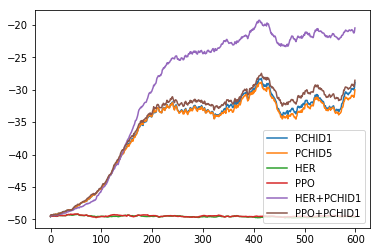

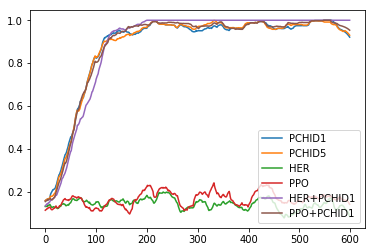

In [35]:
def smooth(y, radius, mode='two_sided', valid_only=False):
    assert mode in ('two_sided', 'causal')
    if len(y) < 2*radius+1:
        return np.ones_like(y) * y.mean()
    elif mode == 'two_sided':
        convkernel = np.ones(2 * radius+1)
        out = np.convolve(y, convkernel,mode='same') / np.convolve(np.ones_like(y), convkernel, mode='same')
        if valid_only:
            out[:radius] = out[-radius:] = np.nan
    elif mode == 'causal':
        convkernel = np.ones(radius)
        out = np.convolve(y, convkernel,mode='full') / np.convolve(np.ones_like(y), convkernel, mode='full')
        out = out[:-radius+1]
        if valid_only:
            out[:radius] = np.nan
    return out

'''plot reward'''
vis_result = {}
for METHOD in ['PCHID1','PCHID5', 'HER', 'PPO', 'HER+PCHID1', 'PPO+PCHID1']:
    vis_result[METHOD] = []
    for repeat in range(5):
        vis_result[METHOD].append(smooth(np.load('saved_files/method_{}_repeat{}.npy'.format(METHOD,repeat))[0],20))
    plt.plot(np.mean(vis_result[METHOD],0),label = METHOD)
plt.legend(loc='lower right')
plt.show()

'''plot SR'''
vis_result = {}
for METHOD in ['PCHID1','PCHID5', 'HER', 'PPO', 'HER+PCHID1', 'PPO+PCHID1']:
    vis_result[METHOD] = []
    for repeat in range(5):
        vis_result[METHOD].append(smooth(np.load('saved_files/method_{}_repeat{}.npy'.format(METHOD,repeat))[1],20))
    plt.plot(np.mean(vis_result[METHOD],0),label = METHOD)
plt.legend(loc='lower right')
plt.show()

